In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx  # For visualizing graph structures

In [8]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###############################################
# Data Reading and Preprocessing
###############################################
stock_symbol = "AAL"
start_date = "2015-01-01"
end_date = "2025-01-01"

stock_data = yf.download(stock_symbol, start=start_date, end=end_date, auto_adjust=False)
stock_data.reset_index(inplace=True)
stock_data.set_index('Date', inplace=True)

columns_to_normalize = ['Low', 'Open', 'Volume', 'High', 'Close', 'Adj Close']
data_to_normalize = stock_data[columns_to_normalize].values
tensor_data = torch.tensor(data_to_normalize, dtype=torch.float32)
mean = tensor_data.mean(dim=0)
std = tensor_data.std(dim=0)
normalized_data = (tensor_data - mean) / std
df_normalized = pd.DataFrame(normalized_data.numpy(), columns=columns_to_normalize)
df_normalized['Date'] = stock_data.index
data = df_normalized

train_percent = 0.7
val_percent = 0.15
test_percent = 0.15
train_size = int(train_percent * len(data))
val_size = int(val_percent * len(data))
test_size = len(data) - train_size - val_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

feature_columns = ['Low', 'Open', 'High']
target_column = 'Close'

train_features = train_data[feature_columns].values   
train_target = train_data[target_column].values         
val_features = val_data[feature_columns].values
val_target = val_data[target_column].values
test_features = test_data[feature_columns].values
test_target = test_data[target_column].values

train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)
test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

[*********************100%***********************]  1 of 1 completed


In [9]:

###############################################
# Define GAT Layer (Single-head Attention)
###############################################
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True):
        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Linear(in_features, out_features, bias=False)
        # Attention weight parameter a, shape (2*out_features, 1)
        self.a = nn.Parameter(torch.empty(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.W.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h):
        batch_size, num_nodes, _ = h.size()
        Wh = self.W(h)  # (batch, num_nodes, out_features)
        # Pair each node to get representations of i and j
        Wh_i = Wh.unsqueeze(2).repeat(1, 1, num_nodes, 1)
        Wh_j = Wh.unsqueeze(1).repeat(1, num_nodes, 1, 1)
        # Concatenate to shape (batch, num_nodes, num_nodes, 2*out_features)
        cat = torch.cat([Wh_i, Wh_j], dim=3)
        # Calculate attention coefficients e_{ij}, shape (batch, num_nodes, num_nodes)
        e = self.leakyrelu(torch.matmul(cat, self.a).squeeze(3))
        attention = torch.softmax(e, dim=2)
        attention = torch.dropout(attention, p=self.dropout, train=self.training)
        # Calculate new representation for each node
        h_prime = torch.matmul(attention, Wh)  # (batch, num_nodes, out_features)
        if self.concat:
            return torch.relu(h_prime), attention
        else:
            return h_prime, attention

###############################################
# Define GAT Model
###############################################
class GATModel(nn.Module):
    def __init__(self, num_nodes, node_in_features, hidden_size, output_size, dropout=0.6, alpha=0.2):
        super(GATModel, self).__init__()
        self.node_embedding = nn.Linear(node_in_features, hidden_size)
        self.gat = GATLayer(hidden_size, hidden_size, dropout=dropout, alpha=alpha, concat=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, return_attention=False):
        x = x.unsqueeze(-1)
        x = self.node_embedding(x)  
        if return_attention:
            x, attention = self.gat(x)
        else:
            x, _ = self.gat(x)
        x = torch.mean(x, dim=1)    
        x = self.fc_output(x)      
        if return_attention:
            return x, attention
        else:
            return x

###############################################
# Set Hyperparameters and Build Model
###############################################
num_nodes = len(feature_columns)  
node_in_features = 1              
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 100

model = GATModel(num_nodes, node_in_features, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
train_losses = []
val_losses = []
test_losses = []

###############################################
# Training Loop
###############################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Move data to GPU
train_features = train_features.to(device)
train_target = train_target.to(device)
val_features = val_features.to(device)
val_target = val_target.to(device)
test_features = test_features.to(device)
test_target = test_target.to(device)


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(train_features)  # Input shape: (batch, 3)
    loss = criterion(outputs, train_target.unsqueeze(1))
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}')
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_features)
        val_loss = criterion(val_outputs, val_target.unsqueeze(1))
    val_losses.append(val_loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}')
    
    with torch.no_grad():
        test_outputs = model(test_features)
        test_loss = criterion(test_outputs, test_target.unsqueeze(1))
    test_losses.append(test_loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')

Epoch [1/100], Training Loss: 0.7977
Epoch [1/100], Validation Loss: 1.4289
Epoch [1/100], Test Loss: 1.8582
Epoch [2/100], Training Loss: 0.6660
Epoch [2/100], Validation Loss: 1.2338
Epoch [2/100], Test Loss: 1.6067
Epoch [3/100], Training Loss: 0.5438
Epoch [3/100], Validation Loss: 1.0514
Epoch [3/100], Test Loss: 1.3707
Epoch [4/100], Training Loss: 0.4330
Epoch [4/100], Validation Loss: 0.8848
Epoch [4/100], Test Loss: 1.1545
Epoch [5/100], Training Loss: 0.3561
Epoch [5/100], Validation Loss: 0.7290
Epoch [5/100], Test Loss: 0.9566
Epoch [6/100], Training Loss: 0.2908
Epoch [6/100], Validation Loss: 0.5839
Epoch [6/100], Test Loss: 0.7729
Epoch [7/100], Training Loss: 0.2529
Epoch [7/100], Validation Loss: 0.4525
Epoch [7/100], Test Loss: 0.6068
Epoch [8/100], Training Loss: 0.2220
Epoch [8/100], Validation Loss: 0.3364
Epoch [8/100], Test Loss: 0.4599
Epoch [9/100], Training Loss: 0.2164
Epoch [9/100], Validation Loss: 0.2376
Epoch [9/100], Test Loss: 0.3343
Epoch [10/100], Tra

Final Test Loss: 0.0299

Validation Set Metrics:
Mean Absolute Error (MAE): 0.1430
Mean Squared Error (MSE): 0.0213
Root Mean Squared Error (RMSE): 0.1459
Mean Absolute Percentage Error (MAPE): 15.2741

Test Set Metrics:
Mean Absolute Error (MAE): 0.1696
Mean Squared Error (MSE): 0.0299
Root Mean Squared Error (RMSE): 0.1729
Mean Absolute Percentage Error (MAPE): 15.8380


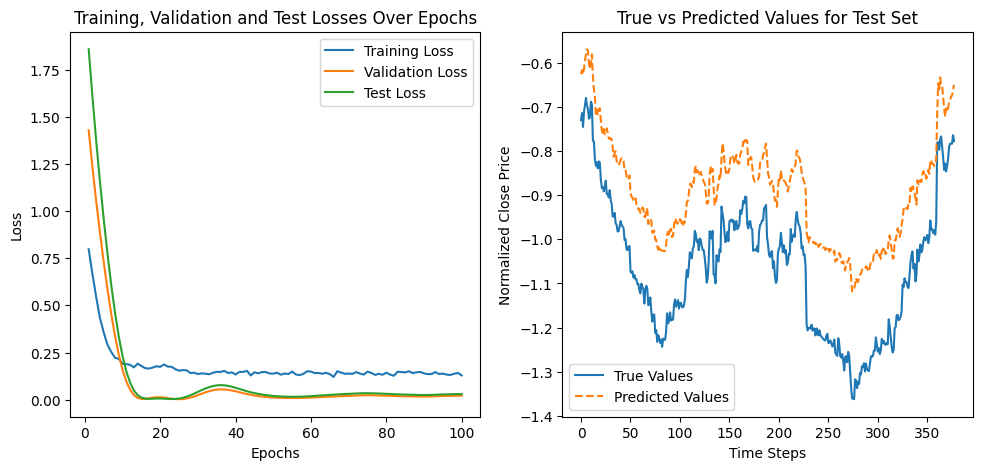

In [12]:


print(f'Final Test Loss: {test_losses[-1]:.4f}\n')

###############################################
# Model Evaluation: Validation and Test Sets
###############################################
model.eval()
with torch.no_grad():
    val_predictions = model(val_features)
val_predictions = val_predictions.squeeze(1).cpu().numpy()
val_target_numpy = val_target.cpu().numpy()

mae_val = mean_absolute_error(val_target_numpy, val_predictions)
mse_val = mean_squared_error(val_target_numpy, val_predictions)
rmse_val = np.sqrt(mse_val)
mape_val = calculate_mape(val_target_numpy, val_predictions)

print('Validation Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_val:.4f}')
print(f'Mean Squared Error (MSE): {mse_val:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_val:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_val:.4f}\n')

with torch.no_grad():
    test_predictions = model(test_features)
test_predictions = test_predictions.squeeze(1).cpu().numpy()
test_target_numpy = test_target.cpu().numpy()

mae_test = mean_absolute_error(test_target_numpy, test_predictions)
mse_test = mean_squared_error(test_target_numpy, test_predictions)
rmse_test = np.sqrt(mse_test)
mape_test = calculate_mape(test_target_numpy, test_predictions)

print('Test Set Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test:.4f}')
print(f'Mean Squared Error (MSE): {mse_test:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_test:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_test:.4f}')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Losses Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(test_target_numpy, label='True Values')
plt.plot(test_predictions, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Close Price')
plt.title('True vs Predicted Values for Test Set')
plt.legend()
plt.show()


Attention Matrix for Sample Input:
[[0.33108446 0.334321   0.3345945 ]
 [0.33108446 0.334321   0.3345945 ]
 [0.33108446 0.334321   0.3345945 ]]


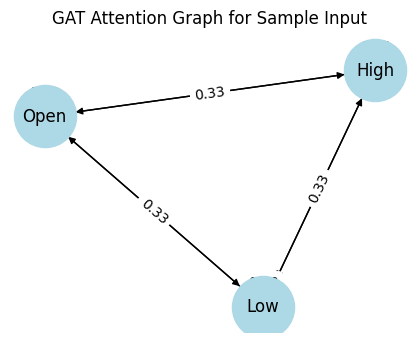

In [ ]:
sample_input = test_features[0:1]  
model.eval()
with torch.no_grad():
    # Pass return_attention=True to get prediction and attention matrix
    _, attention = model(sample_input, return_attention=True)
# attention shape is (batch, num_nodes, num_nodes), take the first one
attn_matrix = attention.squeeze(0).cpu().numpy()  
print("Attention Matrix for Sample Input:")
print(attn_matrix)

nodes = feature_columns
G = nx.DiGraph()
for node in nodes:
    G.add_node(node)

num_nodes = len(nodes)
for i in range(num_nodes):
    for j in range(num_nodes):
        weight = attn_matrix[i, j]
        G.add_edge(nodes[i], nodes[j], weight=weight)

pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title("GAT Attention Graph for Sample Input")
plt.show()
